# L6. Numerical Optimization

> "Economics is the science of optimizing agents," Nikhil Agarwal (2022)

Optimization is ubiquitous in Economics:
- Structural Models: firms maximize profits or minimize cost, consumers maximize utility, the Social Planner maximizes welfare, etc.
- Econometrics: most estimators we use are extremum estimators that arise from minimizing a loss function (OLS, GMM, ML methods) or maximizing a log-likelihood (MLE)
- Dynamic Programming: the RHS of the Bellman equation is an optimization problem
- Game Theory: agents best-respond to each other, i.e., they maximize their payoffs given others' actions

In this lecture we will learn about how numerical optimization methods work so that we know their pros and cons and when to apply them.

All these methods are already implemented efficiently in Julia. If something is already implemented, it is generally a good idea to *not* code your algorithm from scratch, but use the existing implementation. Moreover, this lecture will focus on the basics of how the methods work, but most modern implementations combine these basic principles with clever fine-tunings of various parameters to maximize performance.

## 1. Unconstrained Optimization with ```Optim.jl```
Suppose that we are trying to solve the following problem:
$$\min_{x \in \mathbb{R}^n} f(x).$$

### 1.1. Gradient-Free Methods
Gradient-free methods are direct-search methods, which try to find an optimum without using gradient information.

1. **Nelder-Mead**: The algorithm works as follows. At each step, we start with a set of $n+1$ test points $x_1, \ldots, x_{n+1}$.
    1. If the standard deviation of the function values at those test points is less than a pre-specified tolerance, _stop_. Otherwise, proceed.
    2. _Order_ the test points according to the values at the vertices, so that $$f(x_1) \leq f(x_2) \leq \cdots \leq f(x_{n+1}).$$
    3. Calculate $x_0$, the _centroid_ of all points except $x_{n+1}$.
    4. _Reflection_: Compute the reflected point $x_r = x_0 + \alpha(x_0 - x_{n+1})$ for some pre-specified $\alpha > 0$. If $f(x_1) \leq f(x_r) < f(x_n)$, i.e. the reflected point is better than the second-worst but not better than the best, then replace the worst point $x_{n+1}$ with the reflected point $x_r$ and go back to Step A. Else, continue to _Expansion_ if $f(x_r) < f(x_1)$, or _Contraction_ if $f(x_r) \geq f(x_n)$.
    5. _Expansion_: If $f(x_r) < f(x_1)$, i.e. reflected point is the best point so far, then compute the expanded point $x_e = x_0 + \gamma (x_r - x_0)$ for some pre-specified $\gamma > 1$. If $f(x_e) < f(x_r)$ then replace $x_{n+1}$ with $x_e$ and go back to Step A. Else, replace $x_{n+1}$ with $x_r$ and go back to Step A.
    6. _Contraction_: If $f(x_r) \geq f(x_{n})$, i.e. the reflected point is no better than the second-worse, then:
        1. If $f(x_r) < f(x_{n+1})$, then compute the contracted point on the outside, $x_c = x_0 + \rho(x_r - x_0)$ for a pre-specified $0<\rho\leq 0.5$. If $f(x_c) < f(x_r)$, then replace $x_{n+1}$ with $x_c$ and go back to Step A. Else, proceed to _Shrink_.
        2. If $f(x_r) \geq f(x_{n+1})$, then compute the contracted point on the inside, $x_c = x_0 + \rho(x_{n+1} - x_0)$. If $f(x_c) < f(x_r)$, then replace $x_{n+1}$ with $x_c$ and go back to Step A. Else, proceed to _Shrink_.
     7. _Shrink_: Replace all points except the best $x_1$ with $x_i = x_1 + \sigma (x_i - x_1)$ for some $0 < \sigma \leq 1$, and go back to Step A.
   
Standard values for the parameters are $\alpha = 1$, $\gamma = 2$ and $\rho=\sigma = 1/2$.

(Note: the figure below is for maximization, replace $p_{\max}$ with $x_1$ and $p_{\min}$ with $x_{n+1}$, in this case $x_3$.)

![Nelder-Mead options in a step](https://upload.wikimedia.org/wikipedia/commons/7/72/An-iteration-of-the-Nelder-Mead-method-over-two-dimensional-space-showing-point-p-min.png "Nelder-Mead step")

![Nelder-Mead Search for Rosenbrock Function](https://upload.wikimedia.org/wikipedia/commons/e/e4/Nelder-Mead_Rosenbrock.gif "Nelder-Mead Rosenbrock")

In [1]:
using Optim

# Rosenbrock Function: usual benchmark in numerical optimization
f(x) = (1.0 - x[1])^2 + 100.0*(x[2] - x[1]^2)^2;

# By default, Optim does minimization. Use maximize to do maximization.
# Nelder-Mead is the default algorithm
result = optimize(f, [0.0, 0.0])

 * Status: success

 * Candidate solution
    Final objective value:     3.525527e-09

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    60
    f(x) calls:    117


In [2]:
@show Optim.converged(result)
@show result.minimum
@show result.minimizer;

Optim.converged(result) = true
result.minimum = 3.5255270584829996e-9
result.minimizer = [0.9999634355313174, 0.9999315506115275]


### 1.2. Gradient-Required and Hessian-Required Methods
These methods are based on the idea that, if the function is twice differentiable at the minimizer $x^*$, then the gradient $\nabla f(x^*) = 0$ and the Hessian $H(x^*)$ will be positive (semi-)definite.

1. **Newton Method**: This is based on a linear Taylor approximation of the above:
$$\nabla f(x^*) \approx \nabla f(x) + H(x)(x^* - x),$$ which suggests using the following iterative algorithm: $$x_{t+1} = x_t - H(x_t)^{-1}\nabla f(x_t).$$
2. **Quasi-Newton Methods**: When the Hessian is difficult or computationally expensive to obtain, we might replace it with another positive definite matrix that approximates it:
$$x_{t+1} = x_t - \alpha P^{-1}\nabla f(x_t).$$ 

    One example is **Gradient Descent**, where $P$ is a diagonal matrix. This procedure does not use information about the curvature of the function, and so it can be slow if the problem is ill-conditioned (a small change in $x$ changes $f(x)$ by a lot). In ```Optim.jl```, the scalar $\alpha$ is chosen by linesearch so that each step gives sufficient descent.
    
    Another example is **(L-)BFGS**, which takes as $P$ an approximation to the Hessian using differences in the gradient across iterations. The L-BFGS version of BFGS is a "limited memory" version, that only uses the latest $m$ gradients to approximate the Hessian.    

In [3]:
result = optimize(f, [0.0, 0.0], LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     5.378405e-17

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.54e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.54e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.85e-19 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.29e-03 ≰ 0.0e+00
    |g(x)|                 = 1.21e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    24
    f(x) calls:    67
    ∇f(x) calls:   67


In [4]:
@show Optim.converged(result) 
@show result.minimum
@show result.minimizer;

Optim.converged(result) = true
result.minimum = 5.3784046148998115e-17
result.minimizer = [0.9999999926662393, 0.9999999853324786]


In [17]:
# By default, LBFGS will use finite differences to approximate the gradient of f(x).
# You can also supply the gradient of f directly, either by deriving it analytically
# or with AD:

function g!(G, x)
    G[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
    G[2] = 200.0 * (x[2] - x[1]^2)
end

function h!(H, x)
    H[1, 1] = 2.0 - 400.0 * x[2] + 1200.0 * x[1]^2
    H[1, 2] = -400.0 * x[1]
    H[2, 1] = -400.0 * x[1]
    H[2, 2] = 200.0
end

@time optimize(f, [0.0, 0.0], NelderMead())
@time optimize(f, [0.0, 0.0], LBFGS())
@time optimize(f, [0.0, 0.0], LBFGS(), autodiff=:forward) # i.e. use ForwardDiff.jl
@time optimize(f, g!, [0.0, 0.0], LBFGS())
@time optimize(f, [0.0, 0.0], Newton())
@time optimize(f, [0.0, 0.0], Newton(), autodiff=:forward) # i.e. use ForwardDiff.jl
@time optimize(f, g!, h!, [0.0, 0.0], Newton())

  0.000079 seconds (296 allocations: 7.016 KiB)
  0.000158 seconds (531 allocations: 23.344 KiB)
  0.000068 seconds (597 allocations: 25.516 KiB)
  0.003555 seconds (3.87 k allocations: 228.859 KiB, 98.35% compilation time: 100% of which was recompilation)
  0.000048 seconds (356 allocations: 18.000 KiB)
  0.000086 seconds (390 allocations: 20.125 KiB)
  0.003332 seconds (2.41 k allocations: 145.344 KiB, 98.55% compilation time)


 * Status: success

 * Candidate solution
    Final objective value:     3.081488e-31

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 3.06e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.06e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 9.34e-18 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.03e+13 ≰ 0.0e+00
    |g(x)|                 = 1.11e-15 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    14
    f(x) calls:    44
    ∇f(x) calls:   44
    ∇²f(x) calls:  14


## 2. Constrained Optimization with ```Optim.jl```
Recently, a Julia package previously known as ```ConstrainedOptim.jl``` was merged into ```Optim.jl```. This package supports optimization of the form:
\begin{align*}
\min_{x \in \mathbb{R}^n} \quad & f(x) \\
\text{subj. to} \quad & l_x \leq x \leq u_x \\
& l_c \leq c(x) \leq u_c,
\end{align*}
where $c(x)$ is a vector of constraints. Notice that this includes also equality constraints $c(x) = C$ by defining $l_c = u_c = C$.

```Optim.jl``` currently has one algorithm for this type of problems, Interior Point Newton ```IPNewton()```, which applies Newton's method to the KKT conditions.

To see how it works, let us re-write the problem as:
\begin{align*}
\min_{x \in \mathbb{R}^n, s} \quad & f(x) \\
\text{subj. to} \quad & A(x) - s = 0 \\
& s \geq 0,
\end{align*} 

where we have summarized all constraints in $A(x) \geq 0$, so $A(x) = [(x - l_x)', (u_x - x)', (c(x) - l_c)', (u_c - c(x))']'$, and we have introduced the slack variables $s$.

Then, the KKT conditions are: 
\begin{align*}
\nabla f(x) - \nabla A(x)'\lambda = 0 \\
\mathrm{diag}(s) \lambda = 0 \\
A(x) - s = 0 \\
s \geq 0, \lambda \geq 0
\end{align*}

where $\mathrm{diag}(s)$ is a diagonal matrix with $s$ as its diagonal and $\lambda$ is the vector of Lagrange multipliers. 

Instead of imposing complementary slackness strictly, the method considers $\mathrm{diag}(s) \lambda = \mu_k \mathbf{1}$ for a sequence of $\mu_k \to 0$ as the steps of the maximization proceed. The Newton steps corresponding to the above conditions are: \begin{align*}
\begin{bmatrix}
p_x \\
p_s \\
p_\lambda 
\end{bmatrix} =
\begin{bmatrix}
\nabla^2 f(x) - \nabla^2 A(x)' & 0 &  - \nabla A(x)'\\
0 & \mathrm{diag}(\lambda) & \mathrm{diag}(s) \\
\nabla A(x) & -I & 0
\end{bmatrix}^{-1} \begin{bmatrix}
\nabla f(x) - \nabla A(x)'\lambda \\
\mathrm{diag}(s) \lambda - \mu_k \mathbf{1}\\
A(x) - s
\end{bmatrix}
\end{align*}

and the updates at each step are $x^{k+1} = x^k + \alpha p_x$ where $\alpha \in (0, 1]$ is chosen small enough so that $x$ does not hit the boundary of the feasible region (and likewise for $s$ and $\lambda$).

In [6]:
con_c!(c, x) = (c[1] = x[1]^2 + x[2]^2; c)
lx = [-Inf, -Inf]; ux = [Inf, Inf]
lc = [-Inf]; uc = [0.5^2]
dfc = TwiceDifferentiableConstraints(con_c!, lx, ux, lc, uc)
res = optimize(f, dfc, [0.0, 0.0], IPNewton())

 * Status: success

 * Candidate solution
    Final objective value:     2.966216e-01

 * Found with
    Algorithm:     Interior Point Newton

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.71e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    43
    f(x) calls:    100
    ∇f(x) calls:   100


In [7]:
res.minimizer

2-element Vector{Float64}:
 0.45564896411795214
 0.20587379993150445

## 3. Global Optimization with ```BlackBoxOptim.jl```

A drawback of all the methods we've seen above is that, if the function is not globally strictly convex (concave), the optimizer may converge to a local minimum (maximum). For example:

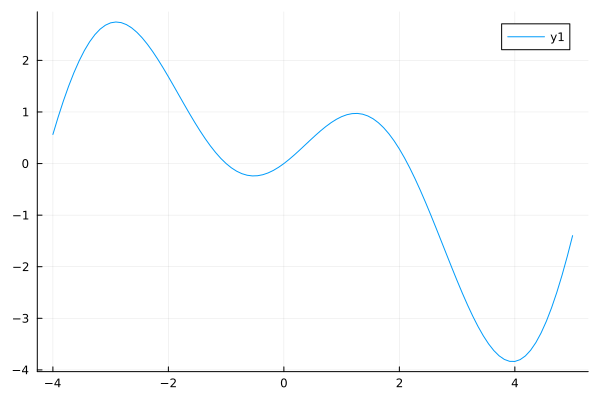

In [8]:
using Plots

g(x) = x * sin(x + 1.0)

plotgrid = range(-4, 5, length=100)
plot(plotgrid, g.(plotgrid))

In [9]:
res = optimize(g, -4.0, 5.0) # A syntax for univariate fns: optimize g between -4.0 and 5.0

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-4.000000, 5.000000]
 * Minimizer: -5.202690e-01
 * Minimum: -2.401252e-01
 * Iterations: 11
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 12

The package ```BlackBoxOptim.jl``` was conceived to perform global optimization in Julia. It uses meta-heuristics, such as [Differential Evolution](https://en.wikipedia.org/wiki/Differential_evolution). These typically involve initializing a number of candidates at different starting points, search for a minimum/maximum starting from those candidates and finally picking the candidate with the lowest/highest value reached. For example:

In [10]:
using BlackBoxOptim

g(x) = x[1] * sin(x[1] + 1.0)

res = bboptimize(g, SearchRange = (-4.0, 5.0), NumDimensions = 1);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.03 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 286061.73
Function evals per second = 288493.01
Improvements/step = 0.29550
Total function evaluations = 10086


Best candidate found: [3.95976]

Fitness: -3.839222897



## 4. JuMP 
[JuMP.jl](https://jump.dev/JuMP.jl/stable/) is an algebraic modeling language for mathematical optimization written in the Julia language. It supports a number of open-source and commercial solvers for a variety of problem classes, including linear, mixed-integer, second-order conic, semidefinite, and nonlinear programming.

MIT Econ provides access through the research servers to two commercial solvers which may be of interest to you: **Knitro** (Nonlinear Interior point Trust Region Optimization), specialized in solving large-scale nonlinear optimization problems, and **Gurobi**, which solves linear, quadratic and mixed-integer programs (more on these in the next section). We won't have time to go into these two solvers in detail here, but I've added some links to the documentation at the end in case you want to learn more.

According to the JuMP documentation, some reasons to use JuMP include:

- User friendliness: JuMP has syntax that mimics natural mathematical expressions.

- Access to advanced algorithmic techniques.

- Solver independence: JuMP is just a generic, solver-independent modeling language, which makes it easier to change between a number of of open-source and commercial optimization software packages ("solvers").

- Ease of embedding: JuMP is written purely in Julia, and provides automatic installation of many open-source solvers. This is different to modeling languages in Python which require you to download and install a solver yourself.

- Speed.

At the same time, there are some situations in which the use of JuMP is not recommended: 

- JuMP doesn't compose well with other Julia packages. If you want to optimize a complicated function that depends on other packages (e.g. a Neural Network from ```Flux.jl```), you should consider ```Optim.jl``` or other alternatives.

- Derivative free or unconstrained optimization. The methods in JuMP require automatic differentiability of the objective function, so if your objective is not differentiable, you woud be better off using the Nelder-Mead option in ```Optim.jl``` or other alternatives. Similarly, even if your problem is differentiable, if it is unconstrained there is limited benefit to using JuMP over tools which are only concerned with function minimization.

- Optimal control problems: there is a package, [InfiniteOpt.jl](https://github.com/infiniteopt/InfiniteOpt.jl), that builds on JuMP for infinite-dimensional optimization problems, such as stochastic or dynamic programming.

We will see an example of how JuMP works in the context of the next section on Linear Programming.

## 5. Linear and Quadratic Programming
A **linear program** is a problem that can be expressed as:
\begin{align*}
\min_{x \in \mathbb{R}^n} \quad & c' x \\
\text{subj. to} \quad & Ax \leq b \\
& x \geq 0.
\end{align*}

Notice that, since the objective and the constraints are linear, looking for stationary points where the derivative of the objective is 0 will not work! 

An algorithm to solve this type of problems is the **simplex** algorithm. At each step, we look at one of the vertices of the feasible region, and we look for an adjacent vertex in which the value of the objective function is improved. If improvement is not possible, then we have found an optimal solution. The idea is simple in practice, but implementing it efficiently with many variables and constraints can be tricky! Luckily, there are packages in Julia that do this for us.

![The simplex algorithm for LP](https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-1-4471-5283-5_3/MediaObjects/311704_1_En_3_Fig6_HTML.gif "Simplex alg.")

Two related problems are:
1. **Quadratic programming**: 
\begin{align*}
\min_{x \in \mathbb{R}^n} \quad & x'Qx + c'x \\
\text{subj. to} \quad & Ax \leq b
\end{align*} 
where the constraints are the same but now the objective is quadratic. This can be solved with the methods above (e.g. interior point methods), but there exist relatively efficient modifications of the simplex algorithm in this case too.

2. **Integer programming**:
\begin{align*}
\min_{x \in \mathbb{Z}^n} \quad & c' x \\
\text{subj. to} \quad & Ax \leq b \\
& x \geq 0.
\end{align*}
with the additional restriction that the components of $x \in \mathbb{Z}^n$ are integer numbers. Mixed-integer problems are those in which some variables must be integers, but other variables may be continuous.

Below we will use the ```JuMP.jl``` modeling language and the ```HiGHS.jl``` open-source solver to solve a linear program. ```HiGHS.jl``` is based on the high performance dual revised simplex implementation for large-scale linear, quadratic (and mixed-integer) programming.

### 5.1. Example: the cannery problem
Let's take this example from the JuMP documentation. We are trying to minimize the cost of shipping cans from production plants $p\in P$ to markets $m \in M$. Each production plant $p$ has capacity $c_p$, and each market $m$ has a demand $d_m$. The cost of shipping from plant $p$ to market $m$ is $\tau_{pm}$. The problem is therefore:
\begin{align*}
\min_{x \in \mathbb{R}^n} \quad & \sum_{p\in P} \sum_{m \in M} \tau_{pm} x_{pm} \\
\text{subj. to} \quad & \sum_{m \in M} x_{pm} \leq c_p \quad \forall p \in P \\
& \sum_{p \in P} x_{pm} \geq d_m  \quad \forall m \in M \\
& x_{pm} \geq 0 \quad \forall p \in P, \quad \forall m \in M
\end{align*}

In [11]:
using JuMP, HiGHS

data = Dict("plants" => Dict(
        "Seattle" => Dict("capacity" => 350),
        "San-Diego" => Dict("capacity" => 600)
    ),
    "markets" => Dict(
        "New-York" => Dict("demand" => 300),
        "Chicago" => Dict("demand" => 300),
        "Topeka" => Dict("demand" => 300)
    ),
    "costs" => Dict(
        "Seattle => New-York" => 2.5,
        "Seattle => Chicago" => 1.7,
        "Seattle => Topeka" => 1.8,
        "San-Diego => New-York" => 2.5,
        "San-Diego => Chicago" => 1.8,
        "San-Diego => Topeka" => 1.4
        )
)

# Get set of plants and markets
P = keys(data["plants"])
M = keys(data["markets"])

# Function to find costs:
cost(p::String, m::String) = data["costs"]["$p => $m"]

# Define a JuMP model:
model = Model(HiGHS.Optimizer)

# Our decision variables are indexed over the set of plants and markets:
@variable(model, x[P, M] >= 0)

# We need a constraint that each plant can ship no more than its capacity:
@constraint(model, [p in P], sum(x[p, :]) <= data["plants"][p]["capacity"])

# and each market must receive at least its demand:
@constraint(model, [m in M], sum(x[:, m]) >= data["markets"][m]["demand"])

# Our objective is to minimize the transportation distance:
@objective(model, Min, sum(cost(p, m) * x[p, m] for p in P, m in M))

print(model)

In [12]:
# Solve
optimize!(model)
solution_summary(model)

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
5 rows, 6 cols, 12 nonzeros
5 rows, 6 cols, 12 nonzeros
Presolve : Reductions: rows 5(-0); columns 6(-0); elements 12(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 3(900) 0s
          3     1.6800000000e+03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 3
Objective value     :  1.6800000000e+03
HiGHS run time      :          0.00


* Solver : HiGHS

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "kHighsModelStatusOptimal"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 1.68000e+03
  Objective bound    : 0.00000e+00
  Relative gap       : Inf
  Dual objective value : 1.68000e+03

* Work counters
  Solve time (sec)   : 1.87779e-03
  Simplex iterations : 3
  Barrier iterations : 0
  Node count         : -1


In [13]:
# Optimal shipment:

for p in P, m in M
    println(p, " => ", m, ": ", value(x[p, m]))
end

Seattle => Chicago: 300.0
Seattle => Topeka: 0.0
Seattle => New-York: 0.0
San-Diego => Chicago: 0.0
San-Diego => Topeka: 300.0
San-Diego => New-York: 300.0


## 6. Stochastic Optimization

### 6.1. Simulated Annealing 

**Simulated Annealing** is a probabilistic method for approximating  the global optimum of a function. The name of the algorithm comes from annealing in metallurgy, a technique involving heating and controlled cooling of a material to alter its physical properties. Simulated annealing can be used for very hard computational optimization problems where exact algorithms fail; even though it usually achieves an approximate solution to the global minimum, it could be enough for many practical problems. 

The method for sampling points is an adaptation of the Metropolis-Hastings algorithm. At each step $k = 0, \ldots, k_{max}$, let $x_k$ denote the current candidate for the minimizer. Then:

1. $x_k' = \mathrm{neighbor}(x_k)$

2. $T = \mathrm{temperature}(k)$

3. If $\mathrm{P}(f(x_k), f(x_k'), T) \geq u_k$, where $u_k \sim U[0,1]$ then $x_{k+1} = x_k'$. Otherwise, $x_{k+1} = x_k$. 
    
As you can see, to implement the algorithm, we need to specify three functions. The first one is $\mathrm{neighbor}(x)$, which, for a given point, selects a random point closeby. One example would be $\mathrm{neighbor}(x) = x + \epsilon$ where $\epsilon \sim N(0, \sigma^2 I)$. The second one is $T = \mathrm{temperature}(k)$, a function of the current iteration that gives the annealing schedule. The third is the acceptance probability function $\mathrm{P}(f(x), f(x'), T)$, which controls whether we accept the new state or not. In the original simulated annealing algorithm, this was $\exp(-(f(x')-f(x))/T)$. The choices for these functions can have a significant impact on the method's effectiveness. Unfortunately, there are no choices of these parameters that will be good for all problems, and there is no general way to find the best choices for a given problem.

In [14]:
result = optimize(f, [0.0, 0.0], SimulatedAnnealing())

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     8.928066e-03

 * Found with
    Algorithm:     Simulated Annealing

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1001


In [15]:
@show Optim.converged(result) 
@show result.minimum
@show result.minimizer;

Optim.converged(result) = false
result.minimum = 0.008928065627760433
result.minimizer = [1.0083046165851617, 1.007265921159627]


The method did not converge in 1,000 iterations. I checked for up to 100,000,000 and it still didn't converge with that many (although you can see it gets close!).

Simulation-based methods will typically need many iterations to converge as a trade-off for their global convergence properties.

In [16]:
# Use this to throw an error when the method does not converge:
# Syntax: BOOLEAN || if FALSE do this

Optim.converged(result) || error("Failed to converge in $(Optim.iterations(result)) iterations")

LoadError: Failed to converge in 1000 iterations

### 6.2. Stochastic Gradient Methods
In some cases, we may be interested in estimating a parameter that solves the following problem:
$$\theta_0 = \arg\min_{\theta \in \Theta} L(\theta) = \arg\min_{\theta \in \Theta} E[\ell(W, \theta)].$$
Some examples are OLS, LASSO, Ridge, or training a Neural Network. Under regularity conditions, the true parameter will satisfy the following FOC:
$$E[\nabla_{\theta} \ell(W, \theta_0)] = 0.$$

Suppose we have an i.i.d. sample $\{W_i\}_{i=1}^n$. We may estimate $\theta_0$ by optimizing the sample analogue of the problem above:
$$\widehat{\theta} = \arg\min_{\theta \in \Theta} \widehat{L}(\theta) = \frac{1}{n}\sum_{i=1}^n \ell(W_i, \theta).$$
Gradient-based numerical methods would typically solve this by finding a root of the FOC, e.g.:
$$\frac{1}{n}\sum_{i=1}^n \nabla_{\theta} \ell(W_i, \widehat{\theta}) = 0.,$$ for example, by gradient descent.

However, when $n$ is very large, computing the average gradient over the whole sample may be computationally very costly. On the other hand, when the dimension of $\theta$ is large, the minimizer of the sample loss may be quite far from the minimizer of the population loss. The larger the number of parameters, the more features of the data the model can capture, but those features may be noise rather than signal (_overfitting_). For these two reasons, people working with ML models tend to work with **stochastic gradient descent (SGD)** more than pure gradient descent. At each iteration, a mini-batch $B_t \subset \{1, \ldots, n\}$ is randomly selected from within the sample, and the iterations proceed as:
$$\widehat{\theta}_{t+1} = \widehat{\theta}_{t} - \alpha_t \frac{1}{|B_t|}\sum_{i \in B_t} \nabla_{\theta} \ell(W_i, \widehat{\theta}_t)$$

Notice that, because the mini-batch is different at each iteration, there is no guarantee of convergence for this algorithm. Convergence is typically achieved by (a) letting the step size $\alpha_t \to 0$ as training goes on, (b) stopping the training process once an out-of-sample validation measure stabilizes (for example, the average loss on a test sample, which is not used in training).

## 7. Recap of Best Practices

1. **Using pre-existing solvers:** As I mentioned above, in general you should try to avoid coding your own optimizer, and use the pre-existing implementations. People who probably have more experience with Julia than you have worked for very long on those! That being said, make sure that you understand the methods you're using, read the documentation for the packages and are aware of the advantages and disadvantages of a method or a solver.

2. **Finding a global vs. a local optimum:** If you're not sure whether your problem is strictly convex you can find a possibly local optimum (say with ```Optim.jl```) and then try optimizing again with that point plus some random noise in different directions as a starting value. In general, even if you think your problem is convex, it is always a good idea to verify that the optimum does not depend on the starting value. 

3. **After optimizing:** Read the exit code to make sure that the optimizer achieved convergence. It is a good practice to write code to throw an error and stop automatically if convergence was not achieved. If your problem is twice differentiable, it could be a good idea to verify that the F.O.C. and S.O.C. are satisfied.

4. **Test:** Whenever possible, it is a good idea to verify that the solvers are working properly with toy examples for which you can find the analytic solution easily. In other cases, e.g. if your optimization is part of an estimation problem, you can design a Monte-Carlo simulation, where you generate random draws of data from the model for known values of the parameters, and see if your estimation procedure can recover those parameters accurately.

## Additional Resources
- Quantitative Economics with Julia: [Solvers, Optimizers, and Automatic Differentiation](https://julia.quantecon.org/more_julia/optimization_solver_packages.html)

- Fedor Iskhakov's Foundations of Computational Economics course: [More on Newton-Raphson method](https://github.com/fediskhakov/CompEcon/blob/main/23_mutivariate_newton.ipynb)

- Judd (1998) Chapter 4 and references therein.

- [Introduction to Optimization with Genetic Algorithm](https://towardsdatascience.com/introduction-to-optimization-with-genetic-algorithm-2f5001d9964b) A primer on Evolutionary Algorithms (EA) and the Genetic Algorithm (GA). These are two stochastic optimization methods that are very popular among the ML community. 

- [Knitro](https://www.artelys.com/solvers/knitro/) and its Julia implementation [Knitro.jl](https://www.artelys.com/docs/knitro/3_referenceManual/knitroJuliareference.html)

- [Gurobi](https://www.gurobi.com/solutions/gurobi-optimizer/) and its Julia implementation [Gurobi.jl](https://docs.juliahub.com/Gurobi/do9v6/0.7.7/)